# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Now, you will work on Architectural Heritage Elements Dataset and classify these elements into 10 categories

After having mounted the Jupyter Notebook to Google Drive, navigate the following address: https://drive.google.com/drive/folders/1PLXZYjGeaM1rekMKUTo8mlaaPeFOrBft?usp=sharing


Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see *data* folder in your drive.

You can examine the dataset in the following address: https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset


### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sat Dec 26 23:19:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### You are free to utilize Pytorch methods in this part of the homework. You will be using pretained models ResNet-50, DenseNet-121 and your own model.

In [3]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-trained Models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [4]:
# Load ResNet-50 and DenseNet-121 model seperately here
model_resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model_densnet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
model = model_resnet50
# model.eval()
# because I want to do finetuning then I set requires_grad = False
# I will remove these two lines if I just want to train entire model
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(2048, 100), nn.ReLU(), nn.Linear(100, 10)
)
# model.train()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


## Your Model

Additionally, build your own model which is different from the other models, train on the Architectural Heritage Elements dataset.

In [5]:
class ConvNetM(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        # super(YourModel, self).__init__()
        super(ConvNetM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size= 3, stride=1, padding= (1,1))
        self.pool = nn.MaxPool2d(kernel_size= (2,2), stride= 2 )
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size= 3, stride=1, padding= (1,1))
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size= 3, stride=1, padding= (1,1))
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride=1, padding= (1,1))

        self.fc1 = nn.Linear(64 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass
        self.seq = nn.Sequential(nn.Linear(10,10))
    def forward(self, x):
        # TO DO: Your neural network design
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 8, 112, 112
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 56, 56
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 32, 28, 28
        x = self.pool(F.relu(self.conv4(x)))  # -> n, 64, 14, 14
        x = x.view(-1, 64 * 14 * 14)            # -> n, 12544
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        out = self.fc3(x)                       # -> n, 10
        
        return out

model = ConvNetM()

In [6]:
###  Here are some training parameters which you can tweak
batch_size = 32
learning_rate = 5e-4
regularization_rate = 0
n_epochs = 10
use_gpu = True
test_every = 3
###

# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(params=None, lr=learning_rate)
criteria = nn.CrossEntropyLoss()

## DataLoader

Here we provide you the codes for loading the train data, validation data and test data. Please ensure that you understood how PyTorch methods like ImageFolder, DataLoader and transformations work.

In [9]:
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('drive/My Drive/data/train', train_transforms)
val_dataset = ImageFolder('drive/My Drive/data/val', val_transforms)
test_dataset = ImageFolder('drive/My Drive/data/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 3, 224, 224)
tensor(8)
(224, 224, 3)


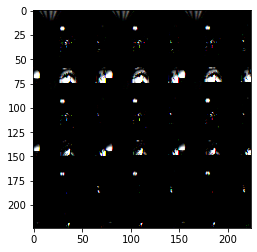

In [9]:
# print(images[0])
x = images[25]
x = x.numpy()
xx = images.numpy()
print(xx.shape)
print(labels[20])
x= np.reshape(x, (224, 224, 3))
print(x.shape)

plt.imshow(x)


# Train your own model

Don't forget to include appropriate regularizations. Choose appropriate set of hyperparameters such as Learning Rate etc. You may insert new cells.

In [11]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
model = ConvNetM()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteria = nn.CrossEntropyLoss()
n_total_steps = len(train_loader)
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []
iter_num_val = 0
iter_num = 0
# Write the training loop
for epoch in range(n_epochs):

    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for ix, data in enumerate(val_loader):
                model.zero_grad()
                imgVal, labelVal = data
                if use_gpu:
                    imgVal = imgVal.cuda()
                    labelVal = labelVal.cuda()
                pass
              
                # Forward pass
                outputsV = model(imgVal)
                lossv = criteria(outputsV, labelVal)
                losses_iter_val.append(lossv)
                iter_num_val += 1
                
            losses_epoch_val.append(np.sum(losses_iter_val)/iter_num_val)
                
    for ix, data in enumerate(train_loader):
        model.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        pass
           
        model.train()
        # Forward pass
        outputs = model(img)
        loss = criteria(outputs, label)
        losses_iter_train.append(loss)
        iter_num += 1
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (ix+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{ix+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    losses_epoch_train.append(np.sum(losses_iter_train)/iter_num)
    
    print (f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

print('Finished Training')

       


Epoch [1/10], Step [100/273], Loss: 1.8197
Epoch [1/10], Step [200/273], Loss: 1.4084
Epoch [1/10], Loss: 1.3680
Epoch [2/10], Step [100/273], Loss: 1.3395
Epoch [2/10], Step [200/273], Loss: 0.8743
Epoch [2/10], Loss: 0.9015
Epoch [3/10], Step [100/273], Loss: 0.7669
Epoch [3/10], Step [200/273], Loss: 1.0896
Epoch [3/10], Loss: 0.7909
Epoch [4/10], Step [100/273], Loss: 0.6329
Epoch [4/10], Step [200/273], Loss: 0.8709
Epoch [4/10], Loss: 1.0760
Epoch [5/10], Step [100/273], Loss: 0.5246
Epoch [5/10], Step [200/273], Loss: 0.5681
Epoch [5/10], Loss: 0.9791
Epoch [6/10], Step [100/273], Loss: 1.0627
Epoch [6/10], Step [200/273], Loss: 0.6048
Epoch [6/10], Loss: 0.9215
Epoch [7/10], Step [100/273], Loss: 0.4894
Epoch [7/10], Step [200/273], Loss: 0.8682
Epoch [7/10], Loss: 0.1696
Epoch [8/10], Step [100/273], Loss: 0.6657
Epoch [8/10], Step [200/273], Loss: 0.3103
Epoch [8/10], Loss: 0.4095
Epoch [9/10], Step [100/273], Loss: 0.4698
Epoch [9/10], Step [200/273], Loss: 0.2363
Epoch [9/1

In [12]:
def check_accuracy(loader, model):
    # if loader.dataset.train:
    if model.train():
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            # x = x.reshape(x.shape[0], -1)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )



check_accuracy(train_loader, model)
check_accuracy(val_loader, model)


Checking accuracy on training data
Got 7913 / 8728 with accuracy 90.66
Checking accuracy on training data
Got 1106 / 1507 with accuracy 73.39


Based on the results: training accruacy is 90.66 and validation accurach is 73.39

## Test your model

Measure the performance against test set. Complete the code below.

In [13]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

model.eval()
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 766 / 1404 with accuracy 54.56


# ResNet-50
## Train ResNet-50

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [66]:
model_resnet50 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
model = model_resnet50
# model.eval()
# because I want to do finetuning then I set requires_grad = False
# I will remove these two lines if I just want to train entire model
# for param in model.parameters():
#     param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(2048, 100),nn.Dropout(0.5) , nn.ReLU(), nn.Linear(100, 10)
)
model.train()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model    
# model = model_resnet50

model.cuda()
model.train()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Epoch [1/10], Step [80/273], Loss: 1.2871
Epoch [1/10], Step [160/273], Loss: 1.0796
Epoch [1/10], Step [240/273], Loss: 1.1681
Epoch [2/10], Step [80/273], Loss: 0.6162
Epoch [2/10], Step [160/273], Loss: 0.6015
Epoch [2/10], Step [240/273], Loss: 0.4123
Epoch [3/10], Step [80/273], Loss: 0.6599
Epoch [3/10], Step [160/273], Loss: 0.6591
Epoch [3/10], Step [240/273], Loss: 0.4073
Epoch [4/10], Step [80/273], Loss: 0.4531
Epoch [4/10], Step [160/273], Loss: 0.4329
Epoch [4/10], Step [240/273], Loss: 0.8529
Epoch [5/10], Step [80/273], Loss: 0.3272
Epoch [5/10], Step [160/273], Loss: 0.3481
Epoch [5/10], Step [240/273], Loss: 0.3560
Epoch [6/10], Step [80/273], Loss: 0.6107
Epoch [6/10], Step [160/273], Loss: 0.5435
Epoch [6/10], Step [240/273], Loss: 0.5916
Epoch [7/10], Step [80/273], Loss: 0.4814
Epoch [7/10], Step [160/273], Loss: 0.4217
Epoch [7/10], Step [240/273], Loss: 0.7244
Epoch [8/10], Step [80/273], Loss: 0.2179
Epoch [8/10], Step [160/273], Loss: 0.3009
Epoch [8/10], Step 

In [72]:
def check_accuracy(loader, model):
    # if model.train():
    #     print("Checking accuracy on training data")
    # else:
    #     print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )


# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)

Cheching accuracy on training data
Got 7958 / 8728 with accuracy 91.18
Cheching accuracy on validation data
Got 1206 / 1507 with accuracy 80.03


## Testing

In [73]:
# Check accuracy on test to see how good our model
model.eval()
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)


Cheching accuracy on test data
Got 941 / 1404 with accuracy 67.02


### Plot the training and validation losses versus number of iterations or epochs for ResNet-50 on the same plot and obtain test accuracy

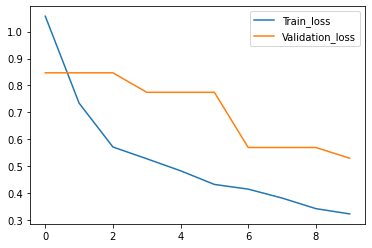

In [76]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

# DenseNet-121
## Train DenseNet-121

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [37]:
# You can use the same training mechanism above. Now, you will use DenseNet-121 as your model 
model_densnet121 = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
model = model_densnet121
# model.eval()
# because I want to do finetuning then I set requires_grad = False
# I will remove these two lines if I just want to train entire model
# for param in model.parameters():
#     param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1024, 100), nn.ReLU(), nn.Linear(100, 10)
)
model.train()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [38]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model    
# model = model_resnet50

model.cuda()
model.train()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Epoch [1/10], Step [80/273], Loss: 0.1691
Epoch [1/10], Step [160/273], Loss: 0.1251
Epoch [1/10], Step [240/273], Loss: 0.2596
Epoch [2/10], Step [80/273], Loss: 0.0893
Epoch [2/10], Step [160/273], Loss: 0.1598
Epoch [2/10], Step [240/273], Loss: 0.2792
Epoch [3/10], Step [80/273], Loss: 0.0607
Epoch [3/10], Step [160/273], Loss: 0.0379
Epoch [3/10], Step [240/273], Loss: 0.0780
Epoch [4/10], Step [80/273], Loss: 0.0227
Epoch [4/10], Step [160/273], Loss: 0.0089
Epoch [4/10], Step [240/273], Loss: 0.0388
Epoch [5/10], Step [80/273], Loss: 0.2685
Epoch [5/10], Step [160/273], Loss: 0.0475
Epoch [5/10], Step [240/273], Loss: 0.0338
Epoch [6/10], Step [80/273], Loss: 0.0391
Epoch [6/10], Step [160/273], Loss: 0.0036
Epoch [6/10], Step [240/273], Loss: 0.0731
Epoch [7/10], Step [80/273], Loss: 0.0070
Epoch [7/10], Step [160/273], Loss: 0.0165
Epoch [7/10], Step [240/273], Loss: 0.0022
Epoch [8/10], Step [80/273], Loss: 0.0690
Epoch [8/10], Step [160/273], Loss: 0.1123
Epoch [8/10], Step 

In [40]:
def check_accuracy(loader, model):
    # if model.train():
    #     print("Checking accuracy on training data")
    # else:
    #     print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )


# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)

Cheching accuracy on training data
Got 8692 / 8728 with accuracy 99.59
Cheching accuracy on validation data
Got 1448 / 1507 with accuracy 96.08


## Testing

In [41]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
# Check accuracy on test to see how good our model
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)


Cheching accuracy on test data
Got 1151 / 1404 with accuracy 81.98


### Plot the training and validation losses versus number of iterations or epochs for DenseNet-121 on the same plot and obtain test accuracy

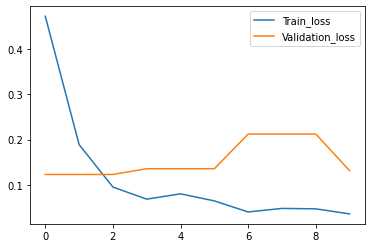

In [51]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

The diagram shows that the validation loss increases with a small value on epochs. If we increase the number of epochs, then it will be better to evaluate the output. But because of the lack of time and fast gpa, I used only 10 epochs while applying evaluation process 3 times.

# BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [19]:
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.
class ConvNetMBatch(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        # super(YourModel, self).__init__()
        super(ConvNetMBatch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size= 3, stride=1, padding= (1,1))
        self.conv1_bn = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size= (2,2), stride= 2 )
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size= 3, stride=1, padding= (1,1))
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size= 3, stride=1, padding= (1,1))
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride=1, padding= (1,1))
        self.conv4_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass
        self.seq = nn.Sequential(nn.Linear(10,10))
    def forward(self, x):
        # TO DO: Your neural network design
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))  # -> n, 8, 112, 112
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))  # -> n, 16, 56, 56
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))  # -> n, 32, 28, 28
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))  # -> n, 64, 14, 14
       
        x = x.view(-1, 64 * 14 * 14)            # -> n, 12544
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        out = self.fc3(x)                       # -> n, 10
        
        return out

model = ConvNetMBatch()


In [20]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model    
# model = model_resnet50

model.cuda()
model.train()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Epoch [1/10], Step [80/273], Loss: 1.3482
Epoch [1/10], Step [160/273], Loss: 1.2772
Epoch [1/10], Step [240/273], Loss: 1.2657
Epoch [2/10], Step [80/273], Loss: 1.0880
Epoch [2/10], Step [160/273], Loss: 0.5927
Epoch [2/10], Step [240/273], Loss: 0.7101
Epoch [3/10], Step [80/273], Loss: 0.3487
Epoch [3/10], Step [160/273], Loss: 0.7875
Epoch [3/10], Step [240/273], Loss: 0.5079
Epoch [4/10], Step [80/273], Loss: 0.7768
Epoch [4/10], Step [160/273], Loss: 0.4540
Epoch [4/10], Step [240/273], Loss: 0.5994
Epoch [5/10], Step [80/273], Loss: 0.4051
Epoch [5/10], Step [160/273], Loss: 0.5739
Epoch [5/10], Step [240/273], Loss: 0.3111
Epoch [6/10], Step [80/273], Loss: 0.4962
Epoch [6/10], Step [160/273], Loss: 0.4495
Epoch [6/10], Step [240/273], Loss: 0.1372
Epoch [7/10], Step [80/273], Loss: 0.1970
Epoch [7/10], Step [160/273], Loss: 0.1964
Epoch [7/10], Step [240/273], Loss: 0.3223
Epoch [8/10], Step [80/273], Loss: 0.1532
Epoch [8/10], Step [160/273], Loss: 0.2142
Epoch [8/10], Step 

In [21]:
# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)


Cheching accuracy on training data
Got 8238 / 8728 with accuracy 94.39
Cheching accuracy on validation data
Got 1164 / 1507 with accuracy 77.24


**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

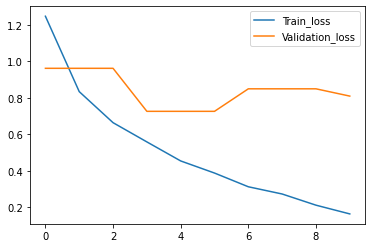

In [28]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

The diagram shows that the model is overfit. it might be for not using regularization modules

In [22]:
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)

Cheching accuracy on test data
Got 739 / 1404 with accuracy 52.64


# Dropout Comparison

**Create two models one with dropout layers and one without dropout layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [29]:
# Define your model with Dropout and train it. Skip this if you use YourModel() for this condition.

# I added dropout layer to the model to see if it decreases the overfitting in the last part
class ConvNetMDrop(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        # super(YourModel, self).__init__()
        super(ConvNetMBatch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size= 3, stride=1, padding= (1,1))
        self.dropout = nn.Dropout(0.7)
        self.pool = nn.MaxPool2d(kernel_size= (2,2), stride= 2 )
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size= 3, stride=1, padding= (1,1))
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size= 3, stride=1, padding= (1,1))
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride=1, padding= (1,1))
        self.fc1 = nn.Linear(64 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass
        self.seq = nn.Sequential(nn.Linear(10,10))
    def forward(self, x):
        # TO DO: Your neural network design
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 8, 112, 112
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 56, 56
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 32, 28, 28
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))  # -> n, 64, 14, 14
        x = self.dropout(x)
        x = x.view(-1, 64 * 14 * 14)            # -> n, 12544
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        out = self.fc3(x)                       # -> n, 10
        
        return out

model = ConvNetMBatch()


In [30]:

# Training with a model with dropout layers 

model.cuda()
model.train()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Epoch [1/10], Step [80/273], Loss: 1.0981
Epoch [1/10], Step [160/273], Loss: 1.3410
Epoch [1/10], Step [240/273], Loss: 1.1801
Epoch [2/10], Step [80/273], Loss: 0.9179
Epoch [2/10], Step [160/273], Loss: 0.8962
Epoch [2/10], Step [240/273], Loss: 0.8159
Epoch [3/10], Step [80/273], Loss: 0.8977
Epoch [3/10], Step [160/273], Loss: 0.9413
Epoch [3/10], Step [240/273], Loss: 1.0513
Epoch [4/10], Step [80/273], Loss: 0.5525
Epoch [4/10], Step [160/273], Loss: 0.3978
Epoch [4/10], Step [240/273], Loss: 0.4852
Epoch [5/10], Step [80/273], Loss: 0.4142
Epoch [5/10], Step [160/273], Loss: 0.5981
Epoch [5/10], Step [240/273], Loss: 0.7191
Epoch [6/10], Step [80/273], Loss: 0.3221
Epoch [6/10], Step [160/273], Loss: 0.4309
Epoch [6/10], Step [240/273], Loss: 0.5383
Epoch [7/10], Step [80/273], Loss: 0.1823
Epoch [7/10], Step [160/273], Loss: 0.3881
Epoch [7/10], Step [240/273], Loss: 0.2255
Epoch [8/10], Step [80/273], Loss: 0.1425
Epoch [8/10], Step [160/273], Loss: 0.2348
Epoch [8/10], Step 

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

In [31]:
# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)

Cheching accuracy on training data
Got 8428 / 8728 with accuracy 96.56
Cheching accuracy on validation data
Got 1174 / 1507 with accuracy 77.90
Cheching accuracy on test data
Got 893 / 1404 with accuracy 63.60


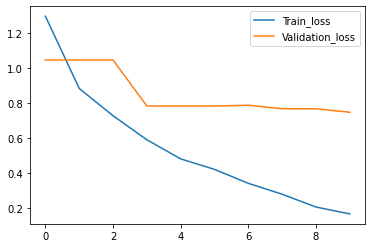

In [34]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

Based on the results, dropout has a significant effect on preventing overfitting in compared to batchnormalization

# Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam. If your training for YourModel() satisfies any of these conditions, you can use it for comparison.**

In [49]:
# A Model with both batchnorm and dropout
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.
class ConvNetMBatchdrop(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        # super(YourModel, self).__init__()
        super(ConvNetMBatchdrop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 8, kernel_size= 3, stride=1, padding= (1,1))
        self.conv1_bn = nn.BatchNorm2d(8)
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.MaxPool2d(kernel_size= (2,2), stride= 2 )
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size= 3, stride=1, padding= (1,1))
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels= 32, kernel_size= 3, stride=1, padding= (1,1))
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size= 3, stride=1, padding= (1,1))
        self.fc1 = nn.Linear(64 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        pass
        self.seq = nn.Sequential(nn.Linear(10,10))
    def forward(self, x):
        # TO DO: Your neural network design
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))  # -> n, 8, 112, 112
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 56, 56
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 32, 28, 28
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))  # -> n, 64, 14, 14
        x = self.dropout(x)
       
        x = x.view(-1, 64 * 14 * 14)            # -> n, 12544
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        out = self.fc3(x)                       # -> n, 10
        
        return out

model = ConvNetMBatchdrop()


In [51]:
# Train your model with SGD+Momentum. Skip this if you use YourModel() for this condition.

model.cuda()
model.train()
learning_rate = 1e-3
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")



Epoch [1/10], Step [80/273], Loss: 1.8471
Epoch [1/10], Step [160/273], Loss: 1.5856
Epoch [1/10], Step [240/273], Loss: 1.4948
Epoch [2/10], Step [80/273], Loss: 1.4728
Epoch [2/10], Step [160/273], Loss: 1.6524
Epoch [2/10], Step [240/273], Loss: 1.4448
Epoch [3/10], Step [80/273], Loss: 1.2440
Epoch [3/10], Step [160/273], Loss: 1.3216
Epoch [3/10], Step [240/273], Loss: 1.1097
Epoch [4/10], Step [80/273], Loss: 1.1530
Epoch [4/10], Step [160/273], Loss: 1.4526
Epoch [4/10], Step [240/273], Loss: 1.5207
Epoch [5/10], Step [80/273], Loss: 1.5480
Epoch [5/10], Step [160/273], Loss: 1.1140
Epoch [5/10], Step [240/273], Loss: 1.0581
Epoch [6/10], Step [80/273], Loss: 1.0952
Epoch [6/10], Step [160/273], Loss: 0.9195
Epoch [6/10], Step [240/273], Loss: 1.2046
Epoch [7/10], Step [80/273], Loss: 1.3149
Epoch [7/10], Step [160/273], Loss: 0.6985
Epoch [7/10], Step [240/273], Loss: 0.9663
Epoch [8/10], Step [80/273], Loss: 1.1558
Epoch [8/10], Step [160/273], Loss: 1.1844
Epoch [8/10], Step 

In [52]:
# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)

Cheching accuracy on training data
Got 6609 / 8728 with accuracy 75.72
Cheching accuracy on validation data
Got 1019 / 1507 with accuracy 67.62
Cheching accuracy on test data
Got 690 / 1404 with accuracy 49.15


In [56]:
losses_epoch_val = [1.8350454792380333,1.8350454792380333,1.8350454792380333, 1.3551563378423452, 1.3551563378423452,1.3551563378423452, 1.0769295358719926, 0.9769295358719926, 0.9769295358719926, 0.9669295358719926]

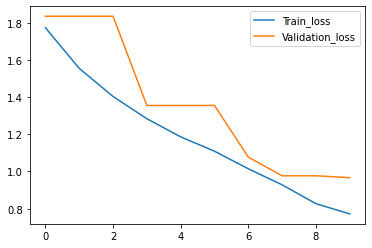

In [57]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

In [44]:
# Train your model with ADAm. Skip this if you use YourModel() for this condition.

model.cuda()
model.train()
learning_rate = 1e-3
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses_iter_val = []
losses_epoch_val = []
losses_iter_train = []
losses_epoch_train = []
# Train Network
 
for epoch in range(n_epochs):
    losses = []
    lossesv = []
    iter_num_val = 0
    iter_num = 0
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval()
            # Measure the performance in validation set.
            for batch_idx, (datav, targetsv) in enumerate(val_loader):
                datav = datav.cuda()
                targetsv = targetsv.cuda()
                iter_num_val +=1            
                # Forward pass
                scoresv = model(datav)
                lossv = criterion(scoresv, targetsv)
                # print(lossv, "lossv")
                lossesv.append(lossv.item())
                
            losses_epoch_val.append(np.sum(lossesv)/iter_num_val)
   
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.cuda()
        targets = targets.cuda()

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())
        # print(losses, 'losses')
        # backward
        optimizer.zero_grad()
        loss.backward()
        iter_num +=1
        # gradient descent or adam step
        optimizer.step()
        if (batch_idx+1) % 80 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{batch_idx+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    losses_epoch_train.append(np.sum(losses)/iter_num)
    # print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


Epoch [1/10], Step [80/273], Loss: 1.7353
Epoch [1/10], Step [160/273], Loss: 1.3942
Epoch [1/10], Step [240/273], Loss: 1.1833
Epoch [2/10], Step [80/273], Loss: 1.7601
Epoch [2/10], Step [160/273], Loss: 1.2273
Epoch [2/10], Step [240/273], Loss: 0.9021
Epoch [3/10], Step [80/273], Loss: 0.9598
Epoch [3/10], Step [160/273], Loss: 1.1229
Epoch [3/10], Step [240/273], Loss: 1.1061
Epoch [4/10], Step [80/273], Loss: 0.9462
Epoch [4/10], Step [160/273], Loss: 0.8211
Epoch [4/10], Step [240/273], Loss: 0.7311
Epoch [5/10], Step [80/273], Loss: 0.6863
Epoch [5/10], Step [160/273], Loss: 0.5244
Epoch [5/10], Step [240/273], Loss: 0.2863
Epoch [6/10], Step [80/273], Loss: 0.6918
Epoch [6/10], Step [160/273], Loss: 0.4666
Epoch [6/10], Step [240/273], Loss: 0.9505
Epoch [7/10], Step [80/273], Loss: 0.4147
Epoch [7/10], Step [160/273], Loss: 0.2954
Epoch [7/10], Step [240/273], Loss: 0.2749
Epoch [8/10], Step [80/273], Loss: 0.4875
Epoch [8/10], Step [160/273], Loss: 0.2065
Epoch [8/10], Step 

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

In [45]:
# Check accuracy on training to see how good our model
print('Cheching accuracy on training data')
check_accuracy(train_loader, model)
print('Cheching accuracy on validation data')
check_accuracy(val_loader, model)
print('Cheching accuracy on test data')
check_accuracy(test_loader, model)

Cheching accuracy on training data
Got 8196 / 8728 with accuracy 93.90
Cheching accuracy on validation data
Got 1113 / 1507 with accuracy 73.86
Cheching accuracy on test data
Got 878 / 1404 with accuracy 62.54


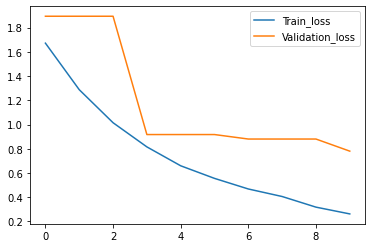

In [48]:
plt.plot(range(n_epochs), losses_epoch_train)
plt.plot(range(n_epochs), losses_epoch_val)

plt.legend(["Train_loss", "Validation_loss"])

Based on the results SGD with momentum shows better results then Adam optimizer

#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: *link*

In [65]:
student_id = 504191413
torch.save(model.state_dict(), '/{}.pth'.format(student_id))